In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
from scipy import interpolate

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 29/04/2020 17:04:51


## Inspect the data

OAPA has shape (239, 239) with diameter=40.07 mm
OAPB has shape (239, 239) with diameter=40.07 mm
OAPC has shape (239, 239) with diameter=40.07 mm
OAPD has shape (239, 239) with diameter=40.07 mm
OAPE has shape (239, 239) with diameter=40.07 mm
OAPF has shape (239, 239) with diameter=40.07 mm
OAPG has shape (239, 239) with diameter=40.07 mm
OAPH has shape (239, 239) with diameter=40.07 mm


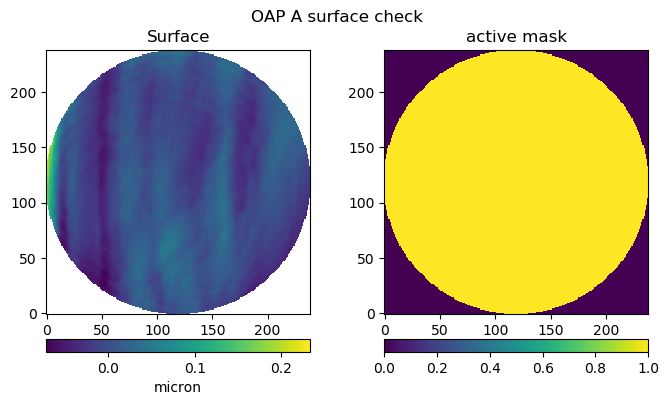

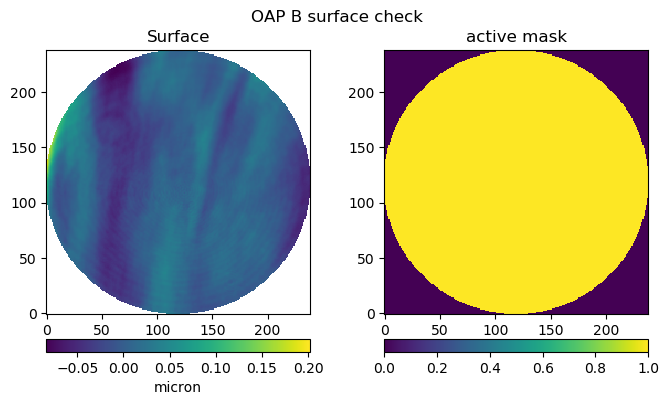

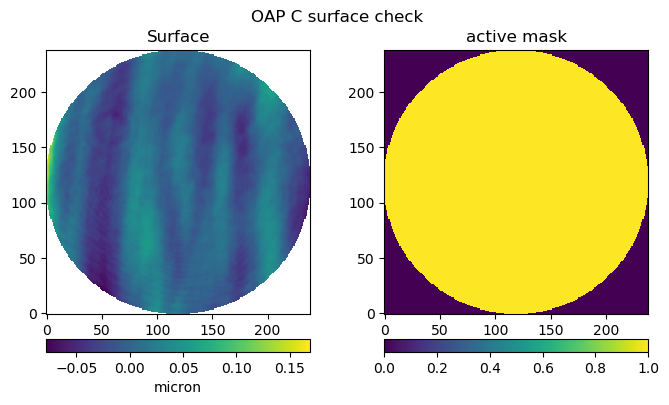

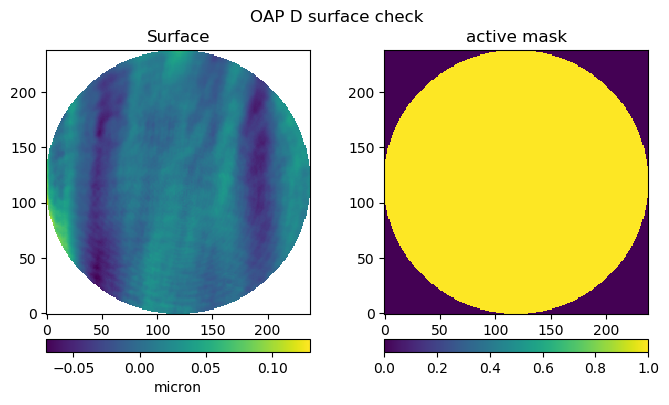

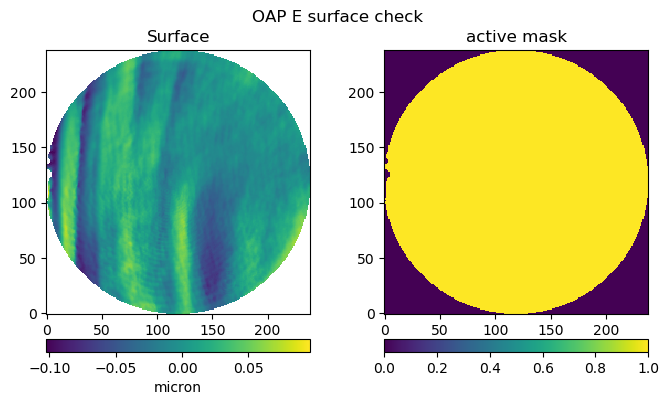

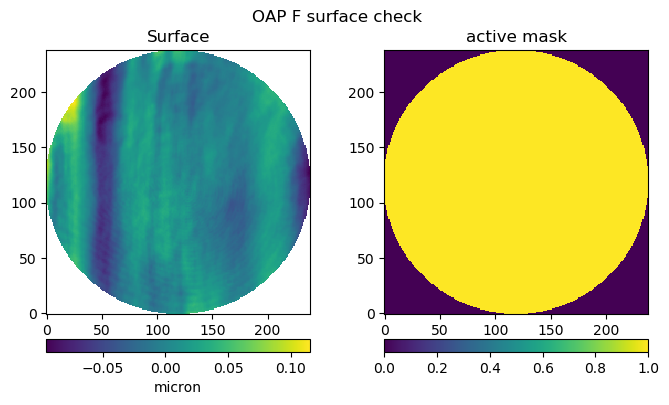

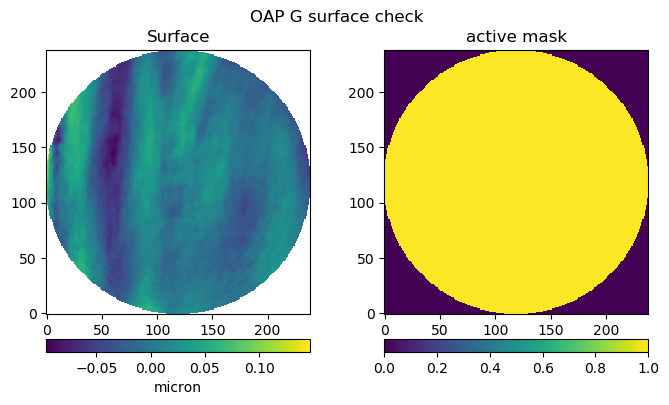

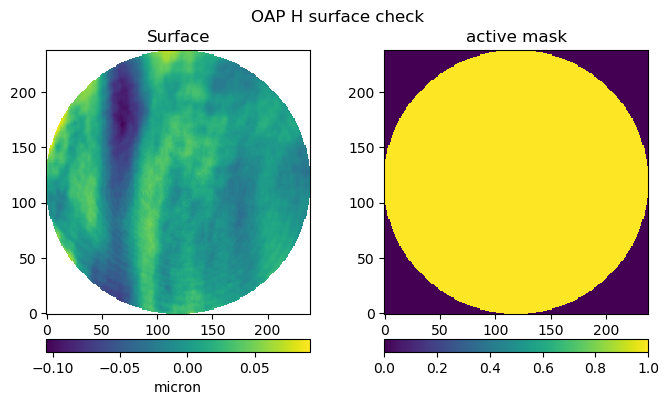

In [15]:
# show all the data for the surfaces for quick inspection
parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')

for surface_name in oap_labels:
    datx_file = 'OAP{0}Unf'.format(surface_name)
    s0, m0, sp0 = dfx.open_datx(data_folder+datx_file+'.datx')
    s0, m0 = dfx.mat_tight(s0,m0) # cut out excess zeros
    diam=(s0.shape[0]*u.pix*sp0['value'][sp0['label'].index('latres')]).to(u.mm)
    print('OAP{0} has shape {1} with diameter={2:.2f}'.format(surface_name, s0.shape, diam))
    supertitle = 'OAP {} surface check'.format(surface_name)
    dfx.show2plots(supertitle=supertitle, 
                   data1=dfx.sn_map(s0, m0), 
                   plot1_label='Surface', 
                   data2=m0.astype(int), 
                   plot2_label='active mask', 
                   set_figsize=[8,4],
                   set_dpi=100)

Visually, there is already something wrong with OAP E. To solve this, we can undersize the aperture to where it's fully clear.

By checking ds9, the diameter must shrink down by 12 pixels total on each axis. (decrease down to ~75% CA)

In [24]:
# resize all the data to one shape, interpolate bad data present

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')

side_cut = 12 # undersize to whole matrix

for surface_name in oap_labels:
    # call in the file
    fileloc = data_folder+'raw/OAP{0}Unf.datx'.format(surface_name)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fileloc, diam_ca100=50*u.mm)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)
    
    # undersize the matrix equally
    #side_cut = mask.shape[0] - min_side + undersize
    if (mask.shape[0] - side_cut) % 2 != 0: # odd new matrix size
        side_cut += 1 # force it even
    surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=side_cut)
    
    latres = sp['value'][sp['label'].index('latres')]
    diam = (latres * mask.shape[0]*u.pix).to(u.mm)
    clear_ap = diam / sp['value'][sp['label'].index('diam_100')] * 100
    print('n{0:5} | diameter: {1:.3f} | clear ap: {2:.2f}% | shape: {3}'.format(surface_name, diam, clear_ap, mask.shape))
    
    # check that there is nothing missing in the data
    if surface_name == 'A': # it's cheating but it's known that the 1st OAP has no bad data inside
        ap_clear = mask
        ap_coords = np.where(mask==1)
    # set up fits header cards
    sp['label'].append('INTERP') # add fits header comment
    sp['comment'].append('True if interpolated bad surf pixels')
    # investigate inside the good aperture
    if (np.where(mask[ap_coords]==0))[0].size >0: # we got bad data
        n_badpix = np.shape(np.where(mask[ap_coords]==0))[1]
        print('OAP{0} has bad data: {1} bad pixels present. Interpolating to fix.'.format(surface_name, n_badpix))
        sp['value'].append(True)
        new_surf = dfx.fill_surface(surf, mask, ap_clear, ap_coords)
    else:
        print('OAP{0} has all good data'.format(surface_name))
        sp['value'].append(False)
        new_surf = surf*ap_clear
        
    # write to file
    new_filename = 'oap{0}_{1}CA'.format(surface_name, int(clear_ap))
    dfx.write_fits(surface=surf, mask=ap_clear, surf_parms=sp, filename=data_folder+new_filename)
    print('OAP{0} file has been written: {1}\n'.format(surface_name, new_filename))

nA     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPA has all good data
OAPA file has been written: oapA_75CA

nB     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPB has all good data
OAPB file has been written: oapB_75CA

nC     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPC has all good data
OAPC file has been written: oapC_75CA

nD     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPD has all good data
OAPD file has been written: oapD_75CA

nE     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPE has all good data
OAPE file has been written: oapE_75CA

nF     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPF has all good data
OAPF file has been written: oapF_75CA

nG     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPG has all good data
OAPG file has been written: oapG_75CA

nH     | diameter: 37.887 mm | clear ap: 75.77% | shape: (226, 226)
OAPH has all good data

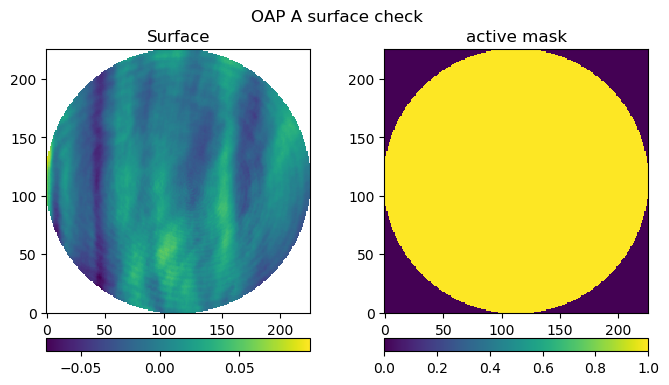

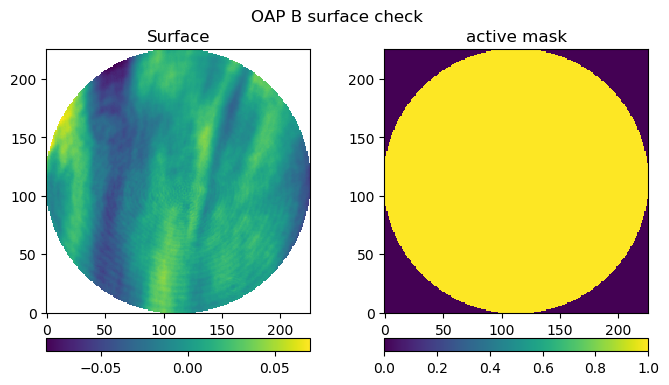

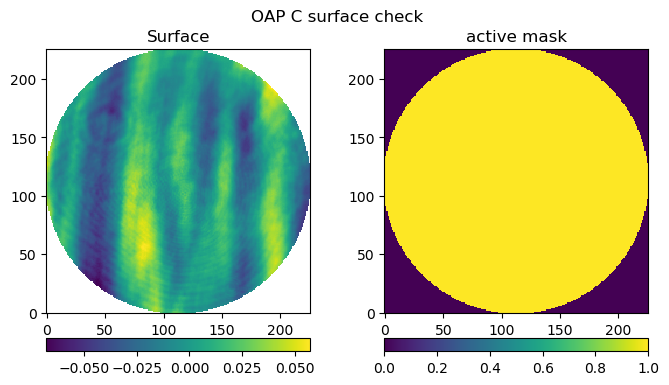

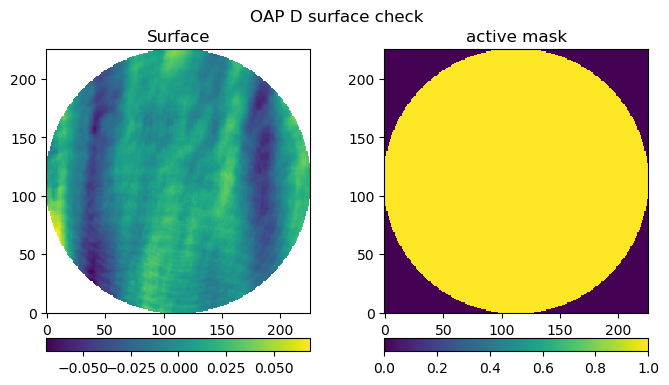

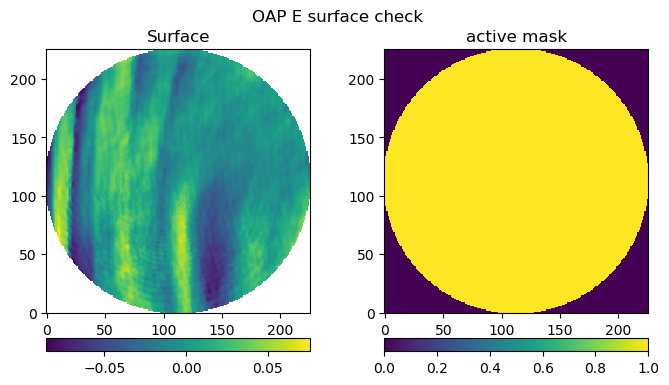

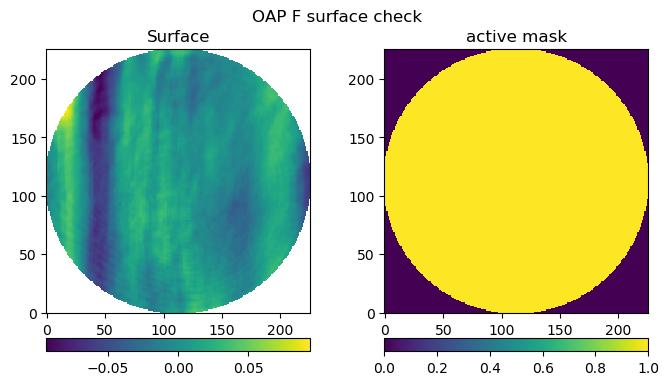

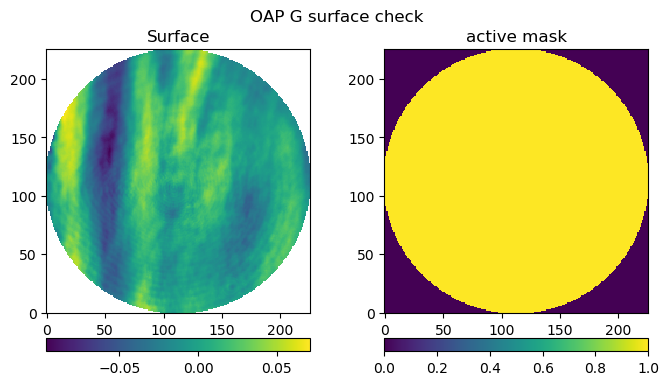

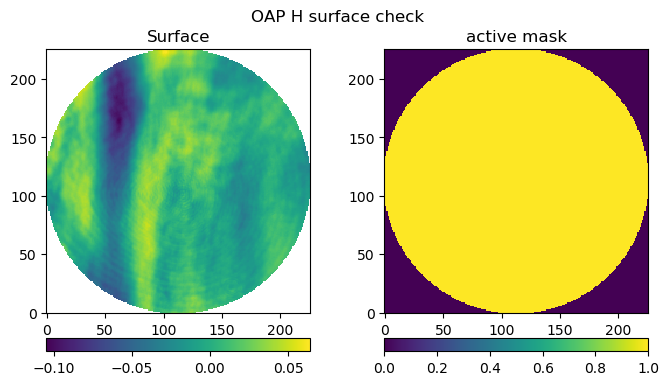

In [25]:
# open the files and show the data is good
for surface_name in oap_labels:
    filename = data_folder+'oap{0}_{1}CA'.format(surface_name, int(clear_ap))
    surf = fits.open(filename+'_surf.fits')[0].data
    mask = fits.open(filename+'_mask.fits')[0].data
    supertitle = 'OAP {} surface check'.format(surface_name)
    dfx.show2plots(supertitle=supertitle, 
                   data1=dfx.sn_map(surf, mask), 
                   plot1_label='Surface', 
                   data2=mask, 
                   plot2_label='active mask', 
                   set_figsize=[8,4],
                   set_dpi=100)